# <font color=red>SMU DS 7331 DATA MINING - MINILAB LOGISTIC REGRESSION AND SVMS</font>

**Team Members:**
- YuMei Bennett
- Liang Huang
- Ganesh Kodi
- Eric McCandless

## <font color=blue>CREATE MODELS (50 POINTS)</font>

**Create a logistic regression model and a support vector machine model for the classification task involved with your dataset. Assess how well each model performs (use 80/20 training/testing split for your data). Adjust parameters of the models to make them more accurate. If your dataset size requires the use of stochastic gradient descent, then linear kernel only is fine to use. That is, the SGDClassifier is fine to use for optimizing logistic regression and linear support vector machines. For many problems, SGD will be required in order to train the SVM model in a reasonable timeframe.**

In [1]:
# import all necessary modules
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import Imputer
import seaborn as sns

#Read in dataset.
col_names = ['age', 'employ_type', 'pop_num', 'edu_level', 'edu_years', 'marital', 'occ', 'relation', 'race', 'gender', 'cap_gain', 'cap_loss', 'hours_week', 'country_orig', 'income']
df = pd.read_csv('adult.csv', names=col_names, header=None)

#Replace "?" with "Other_cat"
df['employ_type'] = df['employ_type'].str.replace('?','Other_cat')
df['occ'] = df['occ'].str.replace('?','Other_cat')
df['country_orig'] = df['country_orig'].str.replace('?','Other_cat')

# Binary encoding of the target variable
df['income'] = df['income'].apply(lambda inc: 0 if inc ==" <=50K" else 1) 

#Transform employ_type into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'employ_type' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['employ_type'], prefix='emp')],axis=1)
df.drop(['employ_type'],axis=1, inplace=True)

#Transform gender into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'gender' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['gender'], prefix='gen')],axis=1)
df.drop(['gender'],axis=1, inplace=True)

#Transform race into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'race' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['race'], prefix='rac')],axis=1)
df.drop(['race'],axis=1, inplace=True)

#Transform education_level into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'edu_level' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['edu_level'], prefix='edu')],axis=1)
df.drop(['edu_level'],axis=1, inplace=True)

#Consolidate education levels because many of them have the similar impact to target income.
df['edu_ SomeCollege'] = df['edu_ Some-college'] + df['edu_ Assoc-acdm'] + df['edu_ Assoc-voc'] 
df['<HS'] = df['edu_ 12th'] + df['edu_ 11th'] + df['edu_ 10th'] + df['edu_ 9th'] + df['edu_ 7th-8th'] + df['edu_ 5th-6th']+ df['edu_ 1st-4th'] + df['edu_ Preschool'] 
df=df.drop(['edu_ Some-college','edu_ Assoc-acdm','edu_ Assoc-voc', 'edu_ 12th', 'edu_ 11th','edu_ 10th','edu_ 9th','edu_ 7th-8th','edu_ 7th-8th','edu_ 5th-6th','edu_ 1st-4th','edu_ Preschool'], 1)

# drop edu_years as it is highly correlated with edu_level.
df=df.drop(['edu_years'], 1)

#Transform relation into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'relation' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['relation'], prefix='rel')],axis=1)
df.drop(['relation'],axis=1, inplace=True)

#Transform marital into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'marital' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['marital'], prefix='mar')],axis=1)
df.drop(['marital'],axis=1, inplace=True)

#Consolidate marital status because too many similar categories.  Married-civ-spouse and Married-AF-spouse are similar as are non-married.
df['Married'] = df['mar_ Married-civ-spouse'] + df['mar_ Married-AF-spouse'] 
df['Sep_Div_Absent_Wid'] = df['mar_ Divorced'] + df['mar_ Separated'] + df['mar_ Widowed'] + df['mar_ Married-spouse-absent']
df['Never_Married'] = df['mar_ Never-married']
df=df.drop(['mar_ Married-civ-spouse','mar_ Married-AF-spouse','mar_ Divorced', 'mar_ Separated', 'mar_ Widowed','mar_ Married-spouse-absent','mar_ Never-married'], 1)

#Transform occ into multiple columns with 0 and 1
# use pd.concat to join the new columns with original dataframe then drop the original 'occ' column (don't need it anymore)
df = pd.concat([df,pd.get_dummies(df['occ'], prefix='occu')],axis=1)
df.drop(['occ'],axis=1, inplace=True)

#Consolidate occupation by combining 'Other-service', 'Other_cat', and 'Armed-Forces. 'Other' categories are combined because they are not defined and Armed-Forces has an extremely small number of occurences.
df['occu_ Other'] = df['occu_ Other-service'] + df['occu_ Other_cat'] + df['occu_ Armed-Forces'] 
df=df.drop(['occu_ Other-service','occu_ Other_cat','occu_ Armed-Forces'], 1)

# drop pop_num as population number is an assigned index number, it has no meaning or contribution to our target income.
df=df.drop(['pop_num'], 1)

# Combine all non-U.S. native countries as only ~10% people are not from US - code native country into binary 1=United-States
df['country_orig'] = df['country_orig'].apply(lambda inc: 1 if inc ==" United-States" else 0) 

# merge capital gain and capital losscap_gain and cap_loss as it can be mathmatically concatenated into a single feature cap_gain_loss = cap_gain - cap_loss.
df['cap_gain-loss'] = df['cap_gain'] - df['cap_loss'] 
df=df.drop(['cap_gain','cap_loss'], 1)
df.head(10)

#Run logistic and supprt vetor machine model
#Use 80/20 training/testing split

,age,hours_week,country_orig,income,emp_ Federal-gov,emp_ Local-gov,emp_ Never-worked,emp_ Other_cat,emp_ Private,emp_ Self-emp-inc,...,occu_ Handlers-cleaners,occu_ Machine-op-inspct,occu_ Priv-house-serv,occu_ Prof-specialty,occu_ Protective-serv,occu_ Sales,occu_ Tech-support,occu_ Transport-moving,occu_ Other,cap_gain-loss
0,39,40,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,2174
1,50,13,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,38,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
3,53,40,1,0,0,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,0
4,28,40,0,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
5,37,40,1,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,0
6,49,16,0,0,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,1,0
7,52,45,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,31,50,1,1,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,14084
9,42,40,1,1,0,0,0,0,1,0,...,0,0,0,0,0,0,0,0,0,5178


In [2]:
from sklearn.model_selection import ShuffleSplit

# we want to predict the X and y data as follows:
if 'income' in df:
    y = df['income'].values # get the labels we want
    del df['income'] # get rid of the class label
    X = df.values # use everything else to predict!

    ## X and y are now numpy matrices, by calling 'values' on the pandas data frames we
    #    have converted them into simple matrices to use with scikit learn
    
    
# to use the cross validation object in scikit learn, we need to grab an instance
#    of the object and set it up. This object will be able to split our data into 
#    training and testing splits
num_cv_iterations = 3
num_instances = len(y)
cv_object = ShuffleSplit(n_splits=num_cv_iterations,
                         test_size  = 0.2)
                         
print(cv_object)

ShuffleSplit(n_splits=3, random_state=None, test_size=0.2, train_size=None)


In [3]:
# run logistic regression and vary some parameters
from sklearn.linear_model import LogisticRegression
from sklearn import metrics as mt

# first we create a reusable logisitic regression object
#   here we can setup the object with different learning parameters and constants
lr_clf = LogisticRegression(penalty='l2', C=1.0, class_weight=None) # get object

# now we can use the cv_object that we setup before to iterate through the 
#    different training and testing sets. Each time we will reuse the logisitic regression 
#    object, but it gets trained on different data each time we use it.

iter_num=0
# the indices are the rows used for training and testing in each iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
    
    # train the reusable logisitc regression model on the training data
    lr_clf.fit(X_train,y_train)  # train object
    y_hat = lr_clf.predict(X_test) # get test set precitions

    # now let's get the accuracy and confusion matrix for this iterations of training/testing
    acc = mt.accuracy_score(y_test,y_hat)
    conf = mt.confusion_matrix(y_test,y_hat)
    print("====Iteration",iter_num," ====")
    print("accuracy", acc )
    print("confusion matrix\n",conf)
    iter_num+=1
    
# Also note that every time you run the above code
#   it randomly creates a new training and testing set, 
#   so accuracy will be different each time

====Iteration 0  ====
accuracy 0.8381698142177184
confusion matrix
 [[4505  369]
 [ 685  954]]
====Iteration 1  ====
accuracy 0.8483033932135728
confusion matrix
 [[4579  342]
 [ 646  946]]
====Iteration 2  ====
accuracy 0.8455396898510671
confusion matrix
 [[4605  378]
 [ 628  902]]


In [44]:
from sklearn.preprocessing import StandardScaler
# we want to normalize the features based upon the mean and standard deviation of each column. 
# However, we do not want to accidentally use the testing data to find out the mean and std (this would be snooping)

from sklearn.pipeline import Pipeline
# you can apply the StandardScaler function inside of the cross-validation loop 
#  but this requires the use of PipeLines in scikit. 
#  A pipeline can apply feature pre-processing and data fitting in one compact notation
#  Here is an example!

std_scl = StandardScaler()
lr_clf = LogisticRegression(penalty='l2', C=0.05) 

# create the pipline
piped_object = Pipeline([('scale', std_scl),  # do this
                         ('logit_model', lr_clf)]) # and then do this

#------------------Commented, since didnt understand the implementation.. Need to discuss-------------
weights = []
# run the pipline cross validated
for iter_num, (train_indices, test_indices) in enumerate(cv_object.split(X,y)):
    piped_object.fit(X[train_indices],y[train_indices])  # train object
    # it is a little odd getting trained objects from a  pipeline:
    weights.append(piped_object.named_steps['logit_model'].coef_[0])
    

weights = np.array(weights)

#-----------------------------------------------------------------------------------------------------

lr_clf.fit(X_train,y_train)  # train object
y_hat = lr_clf.predict(X_test) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf )

C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int6

accuracy: 0.8372485797635498
[[4569  365]
 [ 695  884]]


In [35]:
#----------------------------Why do we need explained above-----------------------------------------
# okay, so run through the cross validation loop and set the training and testing variable for one single iteration
for train_indices, test_indices in cv_object.split(X,y): 
    # I will create new variables here so that it is more obvious what 
    # the code is doing (you can compact this syntax and avoid duplicating memory,
    # but it makes this code less readable)
    X_train = X[train_indices]
    y_train = y[train_indices]
    
    X_test = X[test_indices]
    y_test = y[test_indices]
#-------------------------------------------------------------------------------------------------
    
X_train_scaled = std_scl.transform(X_train) # apply to training
X_test_scaled = std_scl.transform(X_test)

C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)
C:\Users\tempuser\Anaconda3\lib\site-packages\sklearn\utils\validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, DataConversionWarning)


In [36]:
# lets investigate SVMs on the data and play with the parameters and kernels
from sklearn.svm import SVC

# train the model just as before
svm_clf = SVC(C=0.5, kernel='rbf', degree=3, gamma='auto') # get object
svm_clf.fit(X_train_scaled, y_train)  # train object

y_hat = svm_clf.predict(X_test_scaled) # get test set precitions

acc = mt.accuracy_score(y_test,y_hat)
conf = mt.confusion_matrix(y_test,y_hat)
print('accuracy:', acc )
print(conf)

accuracy: 0.8424689083371718
[[4558  376]
 [ 650  929]]


In [37]:
# look at the support vectors
print(svm_clf.support_vectors_.shape)
print(svm_clf.support_.shape)
print(svm_clf.n_support_ )

(9447, 49)
(9447,)
[4917 4530]


In [38]:
# train the model just as before
svm_clf_lin = SVC(kernel='linear')# Linear Kernel
svm_clf_lin.fit(X_train_scaled, y_train)  # train object

y_hat_lin = svm_clf_lin.predict(X_test_scaled) # get test set precitions

acc_lin = mt.accuracy_score(y_test,y_hat_lin)
conf_lin = mt.confusion_matrix(y_test,y_hat_lin)
print('accuracy:', acc_lin )
print(conf_lin)

accuracy: 0.8407799785045295
[[4576  358]
 [ 679  900]]


In [39]:
# train the model just as before
svm_clf_pol = SVC(kernel='poly')# Polynomial Kernel
svm_clf_pol.fit(X_train_scaled, y_train)  # train object

y_hat_pol = svm_clf_pol.predict(X_test_scaled) # get test set precitions

acc_pol = mt.accuracy_score(y_test,y_hat_pol)
conf_pol = mt.confusion_matrix(y_test,y_hat_pol)
print('accuracy:', acc_pol )
print(conf_pol)

accuracy: 0.8383233532934131
[[4564  370]
 [ 683  896]]


## <font color=blue>MODEL ADVANTAGES (10 POINTS)</font>

**Discuss the advantages of each model for each classification task. Does one type of model offer superior performance over another in terms of prediction accuracy? In terms of training time or efficiency? Explain in detail.**

Logistic regression and SVM in linear mode offer similar prediction accuracy. The model taining time in our case runs equal fast, that's probably due to our dataset size is reasonable, not overally large and we are only using linear kernal for SVM. SVM with none linear lernel do take longer time to run compare to LR on the same dataset. 

From mathmatical perspective, Logistoc regression is strickly convex where SVMs are only convex, so that helps LR be faster from an optimization perspective, but that doesn't always translate to faster. Part of this is because, computationally, SVMs are simpler. LR requires computating the exp functin, which is bit more expansive then just max. functionused in SVMs. 

Logistic regression focus on maximize the proabaility of the data. SVM tries to find the separating hyperplane that maximize the diatance of the closest points to the margin. if a point is not a support vector, it doesn't matter. When SVM is run with linear mode, both are about equal effective. LR as its name suggests, can only separate data that is linearly separable. While SVM has the advantage of various different kernel mode, which can be a lot of more useful for dataset that isn't separable (or not very well) with a straight line.   

## <font color=blue>INTERPRET FEATURE IMPORTANCE (30 POINTS)</font>

**Use the weights from logistic regression to interpret the importance of different features for the classification task. Explain your interpretation in detail. Why do you think some variables are more important?**

<HS has weight of -1.683668563486763
Never_Married has weight of -1.2938233963109311
gen_ Female has weight of -1.0164914697061778
rel_ Own-child has weight of -0.9922739345726054
occu_ Other has weight of -0.9090745301190876
edu_ HS-grad has weight of -0.8877944283987392
Sep_Div_Absent_Wid has weight of -0.7895434674019045
emp_ Self-emp-not-inc has weight of -0.6969621236608783
occu_ Farming-fishing has weight of -0.644559824574522
rel_ Unmarried has weight of -0.5977720915386758
occu_ Handlers-cleaners has weight of -0.5703386377199264
edu_ SomeCollege has weight of -0.5294461998231896
occu_ Machine-op-inspct has weight of -0.4683507569007544
rac_ Black has weight of -0.4650959602690044
gen_ Male has weight of -0.4317419409682572
rel_ Other-relative has weight of -0.37318992803984086
emp_ State-gov has weight of -0.30682888596221214
rac_ Asian-Pac-Islander has weight of -0.2989130056611633
rac_ White has weight of -0.2948814078292178
occu_ Transport-moving has weight of -0.2837917456

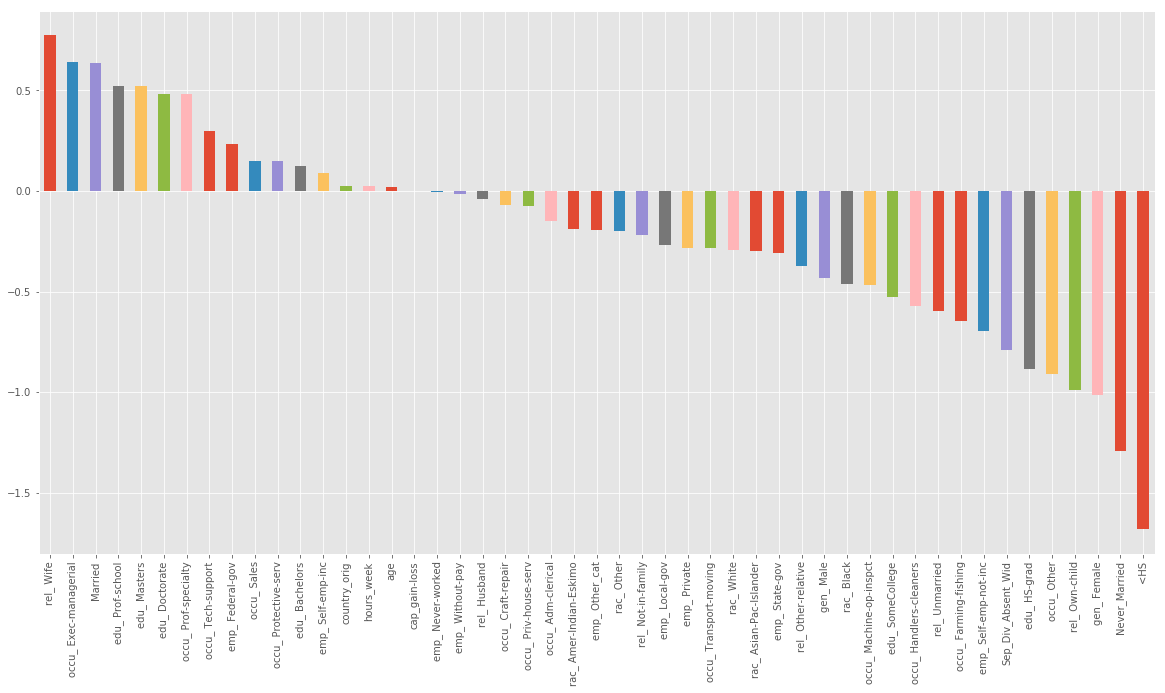

In [40]:
# sort these attributes and spit them out
zip_vars = zip(lr_clf.coef_.T,df.columns) # combine attributes
zip_vars = sorted(zip_vars)
for coef, name in zip_vars:
    print(name, 'has weight of', coef[0]) # now print them out
    
# now let's make a pandas Series with the names and values, and plot them
from matplotlib import pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
plt.figure(figsize = (20,10))
weights = pd.Series(lr_clf.coef_[0],index=df.columns)
weights = weights.sort_values(ascending=False)
weights.plot(kind='bar')
plt.show()

Based on above weightage and bar graph analysis we proceed by weighting features by level of importance and sorting them from highest to lowest in predicting whether or not income level fits into below 55K level or above. We have analysed five important features below
1. cap_gain-loss --> composite feature of capital gain and loss is taking high precendence or strongest predictor of income level with weight value of 1.27 (e^1.27 = 3.56). Odds of person with highest cap_gain_los will tends to falls into > 55K income level increases by a factor of 3.26 than the person with lower cap_gain_loss.
2. Never_Married status of Marital feature -->  Never married status of Martial feature is one of important predictor of income level (in negative) with weight value of -0.450 (e^-0.450 = 0.637). Odds of person with Never Married status will tends to falls into < 55K income level  and making to >55 level decreases by a factor of (1-0.637 = 0.363) than the person with other Marital status level
3. Married status of Marital feature --> Same like Never Married status, Married status person making to >55 level increases by a factor of 1.83 (e^0.605) than the person with other Marital status level. Also it might be corelated with age and experience of married person is more and chances of higher salary is obvious.
4. hours_week --> hours_week of one of the highest  predictor of income level with weight value of 0.363. Odds of person with highest hours_week will tends to falls into > 55K income level increases by a factor of 1.437 than the person with lesser hours_week. Reason  might be due to extra allownaces or with higher responsibility level person tends to work more which is inline with higher salary 
5. Education level  '<HS'  --> <HS level of Education feature is one of the important predictor of income level with weight value (in negative) of -0.395 (e^-0.395 = 0.67). Odds of person with Education lesser than HS will tends to falls into < 55K income level and making to >55 level decreases by a factor of (1-0.7 = 0.33) than the person with other educational level

## <font color=blue>INTERPRET SUPPORT VECTORS (10 POINTS)</font>

**Look at the chosen support vectors for the classification task. Do these provide any insight into the data? Explain. If you used stochastic gradient descent (and therefore did not explicitly solve for support vectors), try subsampling your data to train the SVC model— then analyze the support vectors from the subsampled dataset.**